In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as cm
import datetime
from datetime import timedelta
from epiweeks import Week, Year
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
import statsmodels.nonparametric.smoothers_lowess as lowess
from pandas.plotting import lag_plot
from sklearn.linear_model import LinearRegression
import epiweeks as epi
from scipy.stats import pearsonr as pcr
from scipy.stats import spearmanr as spr
import glob
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
def conv_epiweek(x):
    week=Week.fromdate(pd.to_datetime(x))
    return str(week.year)+'EW'+'{:02}'.format(week.week)

def conv_epiweek_stdate(dt):
    conv_dt=pd.to_datetime(epi.Week.fromdate(pd.to_datetime(dt)).startdate().strftime('%Y-%m-%d'))
    return conv_dt

In [3]:
ssh_df=pd.read_csv('/project/biocomplexity/COVID-19_commons/data/VDH_wastewater/county_mappings/ssh_name_mapping.csv')
ssh_map=dict(zip(ssh_df['new_file_name'],ssh_df['dashboard_name']))

In [4]:
hospdf=pd.read_csv('/project/biocomplexity/COVID-19_commons/data/VDH_wastewater/processed_data/hosp/sewershed/hosp_agg_latest.csv')
hospdf.loc[:,'time_value']=pd.to_datetime(hospdf.time_value)
hospdf.loc[:,'EW']=hospdf.time_value.apply(lambda x: conv_epiweek(x))
hospdf.loc[:,'EW_stdate']=hospdf.time_value.apply(lambda x: conv_epiweek_stdate(x))

In [5]:
df=pd.read_csv('/project/biocomplexity/COVID-19_commons_tmp//data/opioids_url/Sewershed_PCR_Conc.csv',date_parser=True)
df.sample_collect_date=pd.to_datetime(df.sample_collect_date)
df.test_result_date=pd.to_datetime(df.test_result_date)
df.loc[:,'EW']=df.sample_collect_date.apply(lambda x: conv_epiweek(x))
df.loc[:,'EW_stdate']=df.sample_collect_date.apply(lambda x: conv_epiweek_stdate(x))
temp=df.groupby(['sewershed','EW']).size().reset_index().rename(columns={0:'no_of_samples'})
df=df.merge(temp)
df.loc[:,'sewershed']=df.sewershed.replace(ssh_map)

In [17]:
ddf=df[df.no_of_samples==2]
tempdf=ddf.groupby(['EW','EW_stdate','wwtp_name']).mean()['viral_load'].reset_index()#['sample_collect_date'].reset_index()#.rename(columns={'min':'sample_collect_date'})


In [18]:
tempdf

,EW,EW_stdate,wwtp_name,viral_load
0,2022EW10,2022-03-06,Parkins Mill Wastewater Treatment Facili,8.290000e+10
1,2022EW11,2022-03-13,Parkins Mill Wastewater Treatment Facili,1.173000e+10
2,2022EW12,2022-03-20,Parkins Mill Wastewater Treatment Facili,1.317500e+10
3,2022EW13,2022-03-27,Parkins Mill Wastewater Treatment Facili,2.580000e+10
4,2022EW14,2022-04-03,Parkins Mill Wastewater Treatment Facili,4.195000e+10
...,...,...,...,...
588,2023EW38,2023-09-17,North River Wastewater Treatment Facilit,9.785000e+10
589,2023EW38,2023-09-17,Parkins Mill Wastewater Treatment Facili,3.340000e+10
590,2023EW38,2023-09-17,Pepper's Ferry Regional Wastewater Treat,7.975000e+10
591,2023EW38,2023-09-17,Roanoke Regional Water Pollution Control,7.075000e+11


In [64]:
wdf=pd.read_csv('/project/biocomplexity/COVID-19_commons/data/VDH_wastewater/processed_data/wastewater/sewershed/ww_agg_latest.csv')
wdf.loc[:,'time_value']=pd.to_datetime(wdf.time_value)

In [65]:
len(wdf[wdf.time_value>='2023-05-01'].geo_value.unique())

31

In [66]:
ddf=df[df.no_of_samples==2]
temp1=ddf.groupby(['EW','wwtp_name'])['sample_collect_date'].agg([min]).reset_index().rename(columns={'min':'sample_collect_date'})
temp1.loc[:,'test']='test1'
temp2=ddf.groupby(['EW','wwtp_name'])['sample_collect_date'].agg([max]).reset_index().rename(columns={'max':'sample_collect_date'})
temp2.loc[:,'test']='test2'
temp1=temp1.append(temp2)
ddf=ddf.merge(temp1)

In [434]:
locs=ddf.sewershed.unique()
allspdf=pd.DataFrame()
samp='first'
if samp=='second':
    test='test2'
elif samp=='first':
    test='test1'
for l in locs:
    mdf=pd.read_csv('output/slope_pct/{}_{}_two_samples_ST.csv'.format(l,samp))
    mdf.loc[:,'EW']=mdf.sample_collect_date.apply(lambda x: conv_epiweek(x))
    mdf.loc[:,'EW_stdate']=mdf.sample_collect_date.apply(lambda x: conv_epiweek_stdate(x))


    hdf=hospdf[hospdf.geo_value==l]
    codf=mdf.merge(hdf)

    temp=codf[['EW_stdate','log_viral_load','hosps_BOW_7d_avg','sewershed']]

    spdf=get_roll_spear(temp,l,shift=[-2,-1,0,1,2])
    spdf=spdf.dropna(subset=['sewershed','EW_stdate'])
    spdf.pcorr=spdf.pcorr.fillna(0)
    idx=spdf[spdf.pval<=0.05].groupby('EW_stdate')['pcorr'].idxmax()
    bspdf=spdf.loc[idx].rename(columns={'lag':'best_lag','pcorr':'best_corr','pval':'best_pval'})
    spdf=spdf.merge(bspdf,'outer')
    spdf.EW_stdate=pd.to_datetime(spdf.EW_stdate)
    allspdf=allspdf.append(spdf)
    print(l)
    allspdf.to_csv('output/corr_two_samples/{}_sample_correlation.csv'.format(test),index=None)

Parkins Mill
Alexandria Renew
North River
Blacksburg
Pepper's Ferry
Roanoke
Coeburn Norton Wise
Moores Creek
Lynchburg
RockyMount


In [276]:
# mdf=mdf.rename(columns={'sample_collect_date':'time_value'})

In [492]:
test='test2'
allspdf=pd.read_csv('output/corr_two_samples/{}_sample_correlation.csv'.format(test))
allspdf.loc[:,'EW_stdate']=pd.to_datetime(allspdf['EW_stdate'])
bestspdf=allspdf[['sewershed','EW_stdate','best_lag','best_corr','best_pval']].drop_duplicates()
bestspdf.loc[:,'best_lag']=bestspdf.best_lag.astype(float)
# bestspdf.loc[:,'best_corr']=bestspdf.best_corr.fillna(0)


pp=bestspdf.groupby(['sewershed','EW_stdate']).mean()[['best_corr']].reset_index()
# pp.loc[:,'best_corr']=pp.best_corr.fillna(0)
pp.EW_stdate=pp.EW_stdate.dt.strftime('%Y-%m-%d')
pp=pp.sort_values('EW_stdate')
counts=pp[pp.best_corr>0].groupby(['EW_stdate']).size().reset_index().rename(columns={0:'no_of_sites'})


bestspdf.loc[:,'best_lag']=bestspdf.best_lag.astype(float)
# bestspdf.loc[:,'best_corr']=bestspdf.best_corr.fillna(0)


pp=bestspdf.groupby(['sewershed','EW_stdate']).mean()[['best_corr']].reset_index()
# pp.loc[:,'best_corr']=pp.best_corr.fillna(0)
pp.EW_stdate=pp.EW_stdate.dt.strftime('%Y-%m-%d')
pp=pp.sort_values('EW_stdate')
counts=pp[pp.best_corr>0].groupby(['EW_stdate']).size().reset_index().rename(columns={0:'no_of_sites'})

In [493]:
ppl=bestspdf[bestspdf.best_corr>0].groupby(['sewershed','EW_stdate']).mean()[['best_lag']].reset_index()
# pp.loc[:,'best_corr']=pp.best_corr.fillna(0)
ppl.EW_stdate=ppl.EW_stdate.dt.strftime('%Y-%m-%d')
ppl=ppl.sort_values('EW_stdate')

/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/

Text(0.5, 1.0, 'No. of sites')

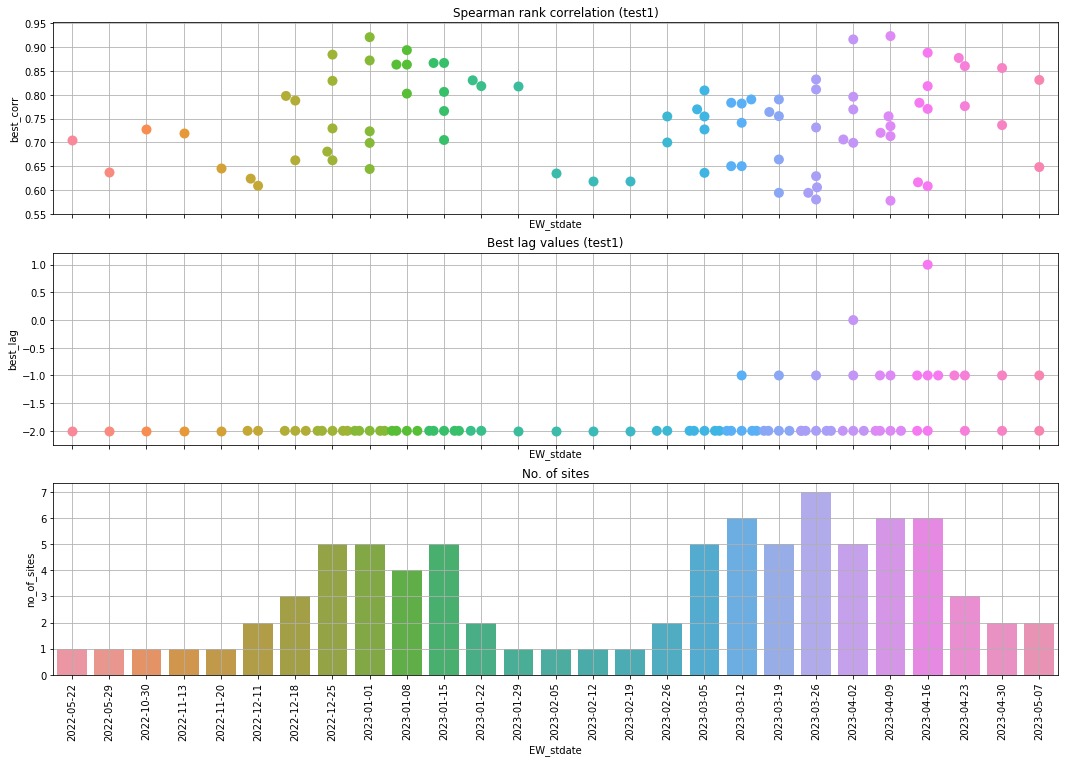

In [491]:
fig,axr=plt.subplots(3,1,figsize=(18,12),sharex=True)
ax=axr[0]
sns.swarmplot(x='EW_stdate', y='best_corr', data=pp[pp.best_corr>0],size=10,ax=ax)
ax.grid()
ax.set_title('Spearman rank correlation ({})'.format(test))
# xticks = ax.get_xticklabels()
# ax.set_xticklabels(xticks,rotation=90)

ax1=axr[1]
# fig,ax1=plt.subplots(1,1,figsize=(18,4),sharex=True)
sns.swarmplot(x='EW_stdate', y='best_lag', data=ppl,size=10,ax=ax1)
ax1.grid()
ax1.set_title('Best lag values ({})'.format(test))
# xticks = ax1.get_xticklabels()
# ax1.set_xticklabels(xticks,rotation=90)

ax2=axr[2]
# fig,ax2=plt.subplots(1,1,figsize=(18,4),sharex=True)
pp[pp.best_corr>0].groupby(['EW_stdate']).size()
sns.barplot(data=counts,x='EW_stdate',y='no_of_sites')
ax2.grid()
xticks = ax2.get_xticklabels()
ax2.set_xticklabels(xticks,rotation=90)
ax2.set_title('No. of sites')


Text(0.5, 1.0, 'No. of sites')

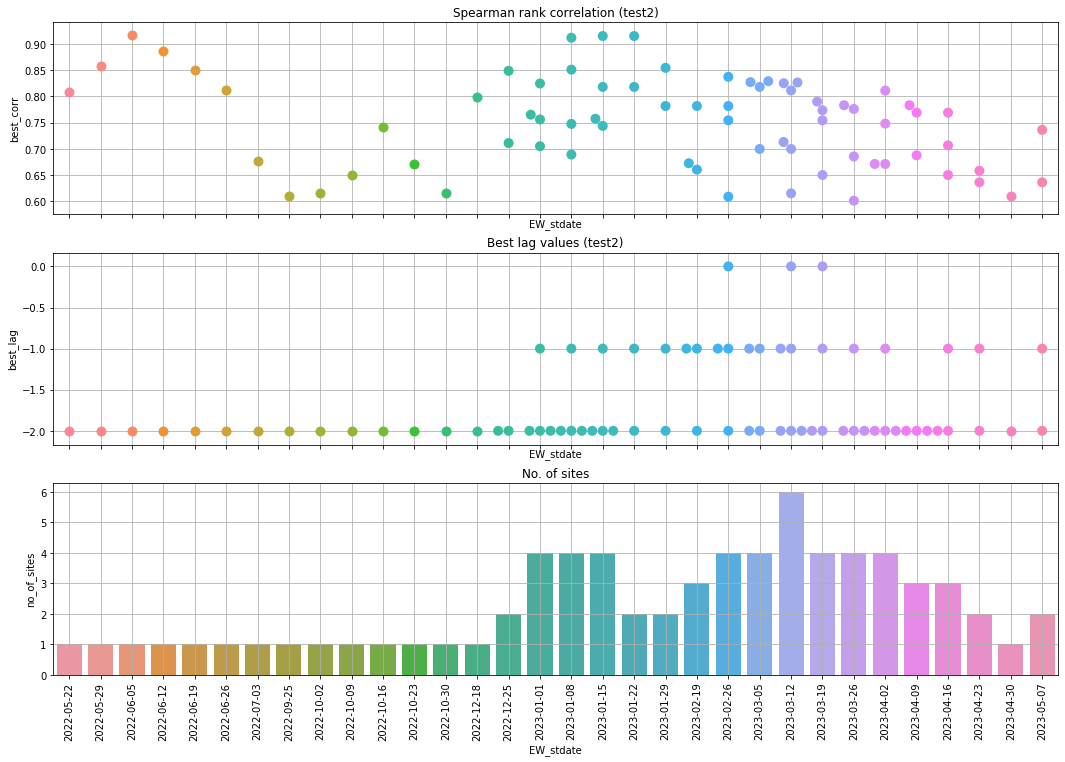

In [495]:
fig,axr=plt.subplots(3,1,figsize=(18,12),sharex=True)
ax=axr[0]
sns.swarmplot(x='EW_stdate', y='best_corr', data=pp[pp.best_corr>0],size=10,ax=ax)
ax.grid()
ax.set_title('Spearman rank correlation ({})'.format(test))
# xticks = ax.get_xticklabels()
# ax.set_xticklabels(xticks,rotation=90)

ax1=axr[1]
# fig,ax1=plt.subplots(1,1,figsize=(18,4),sharex=True)
sns.swarmplot(x='EW_stdate', y='best_lag', data=ppl,size=10,ax=ax1)
ax1.grid()
ax1.set_title('Best lag values ({})'.format(test))
# xticks = ax1.get_xticklabels()
# ax1.set_xticklabels(xticks,rotation=90)

ax2=axr[2]
# fig,ax2=plt.subplots(1,1,figsize=(18,4),sharex=True)
pp[pp.best_corr>0].groupby(['EW_stdate']).size()
sns.barplot(data=counts,x='EW_stdate',y='no_of_sites')
ax2.grid()
xticks = ax2.get_xticklabels()
ax2.set_xticklabels(xticks,rotation=90)
ax2.set_title('No. of sites')

In [32]:
def get_roll_spear(wwdf,loc,shift=[0]):
    twwdf=wwdf[wwdf.sewershed==loc]
    twwdf=twwdf.set_index('EW_stdate')
    pdf=pd.DataFrame(index=np.arange(0,100),columns=['sewershed','EW_stdate','lag','pcorr','pval'])
    win=12
    k=0
    for j in range(0,100):

        endt=twwdf.index.max()-pd.Timedelta(weeks=j)
        stdt=endt-pd.Timedelta(weeks=win-1)
        if stdt<twwdf.index.min():
            break
        res=(np.nan,0,np.nan)
        for i in shift:
            temp1=twwdf.loc[stdt:endt,'log_viral_load']
            temp2=twwdf.shift(i).loc[stdt:endt,'hosps_BOW_7d_avg']
            ind=temp2[temp2.notna()].index
            x1=temp1.loc[ind].values
            x2=temp2.loc[ind].values
            px=spr(x1,x2)
    #         print(endt,i,pcr(x1,x2))
            if px[0]>res[1] and px[1]<=0.05:
                res=(i,px[0],px[1])
            else:
                res=(i,np.nan,px[1])
#         print(endt,res)
            pdf.loc[k,'sewershed']=loc
            pdf.loc[k,'EW_stdate']=endt
            pdf.loc[k,'lag']=res[0]
            pdf.loc[k,'pcorr']=res[1]
            pdf.loc[k,'pval']=res[2]
            k+=1
#         print(j,k,stdt)
    return pdf

In [7]:
one_samp_ss=set(df[(df.sample_collect_date>='2022-09-01')&(df.no_of_samples==1)].sewershed.unique())
two_samp_ss=set(df[(df.sample_collect_date>='2022-09-01')&(df.no_of_samples==2)].sewershed.unique())

In [8]:
only_one_samp=list(one_samp_ss-two_samp_ss)

In [38]:
locs=only_one_samp
allspdf=pd.DataFrame()
samp='only_one'
if samp=='second':
    test='test2'
elif samp=='first':
    test='test1'
elif samp=='only_one':
    test='only_test1'
for l in locs:
    mdf=pd.read_csv('output/slope_pct/{}_one_samples_ST.csv'.format(l,samp))
    mdf.loc[:,'EW']=mdf.sample_collect_date.apply(lambda x: conv_epiweek(x))
    mdf.loc[:,'EW_stdate']=mdf.sample_collect_date.apply(lambda x: conv_epiweek_stdate(x))


    hdf=hospdf[hospdf.geo_value==l]
    codf=mdf.merge(hdf)

    temp=codf[['EW_stdate','log_viral_load','hosps_BOW_7d_avg','sewershed']]

    spdf=get_roll_spear(temp,l,shift=[-2,-1,0,1,2])
    spdf=spdf.dropna(subset=['sewershed','EW_stdate'])
    spdf.pcorr=spdf.pcorr.fillna(0)
    idx=spdf[spdf.pval<=0.05].groupby('EW_stdate')['pcorr'].idxmax()
    bspdf=spdf.loc[idx].rename(columns={'lag':'best_lag','pcorr':'best_corr','pval':'best_pval'})
    spdf=spdf.merge(bspdf,'outer')
    spdf.EW_stdate=pd.to_datetime(spdf.EW_stdate)
    allspdf=allspdf.append(spdf)
    print(l)
#     allspdf.to_csv('output/corr_two_samples/{}_sample_correlation.csv'.format(test),index=None)

Aquia
Virginia Initiative Plant
Wolf Creek
HRSD_YR
HRSD_ATCE
HRSD_AB
Richmond
Nansemond
Lebanon
HRSD_JR
Pound
Upper Occoquan
Little Falls Run
Hillsville
Williamsburg
Onancock
HL Mooney
HRSD_BH
Clintwood
Loudoun


In [121]:
def get_best_corr_lag(allspdf):
    # allspdf=pd.read_csv('output/corr_two_samples/{}_sample_correlation.csv'.format(test))
    allspdf.loc[:,'EW_stdate']=pd.to_datetime(allspdf['EW_stdate'])
    bestspdf=allspdf[['sewershed','EW_stdate','best_lag','best_corr','best_pval']].drop_duplicates()
    bestspdf.loc[:,'best_lag']=bestspdf.best_lag.astype(float)
    # bestspdf.loc[:,'best_corr']=bestspdf.best_corr.fillna(0)


    pp=bestspdf.groupby(['sewershed','EW_stdate']).mean()[['best_corr']].reset_index()
    # pp.loc[:,'best_corr']=pp.best_corr.fillna(0)
    pp.EW_stdate=pp.EW_stdate.dt.strftime('%Y-%m-%d')
    pp=pp.sort_values('EW_stdate')
    counts=pp[pp.best_corr>0].groupby(['EW_stdate']).size().reset_index().rename(columns={0:'no_of_sites'})


    bestspdf.loc[:,'best_lag']=bestspdf.best_lag.astype(float)
    # bestspdf.loc[:,'best_corr']=bestspdf.best_corr.fillna(0)


    pp=bestspdf.groupby(['sewershed','EW_stdate']).mean()[['best_corr']].reset_index()
    # pp.loc[:,'best_corr']=pp.best_corr.fillna(0)
    pp.EW_stdate=pp.EW_stdate.dt.strftime('%Y-%m-%d')
    pp=pp.sort_values('EW_stdate')
    counts=pp[pp.best_corr>0].groupby(['EW_stdate']).size().reset_index().rename(columns={0:'no_of_sites'})

    ppl=bestspdf[bestspdf.best_corr>0].groupby(['sewershed','EW_stdate']).mean()[['best_lag']].reset_index()
    # pp.loc[:,'best_corr']=pp.best_corr.fillna(0)
    ppl.EW_stdate=ppl.EW_stdate.dt.strftime('%Y-%m-%d')
    ppl=ppl.sort_values('EW_stdate')
    return pp,ppl

/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 22.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/

Text(0.5, 1.0, 'No. of sites')

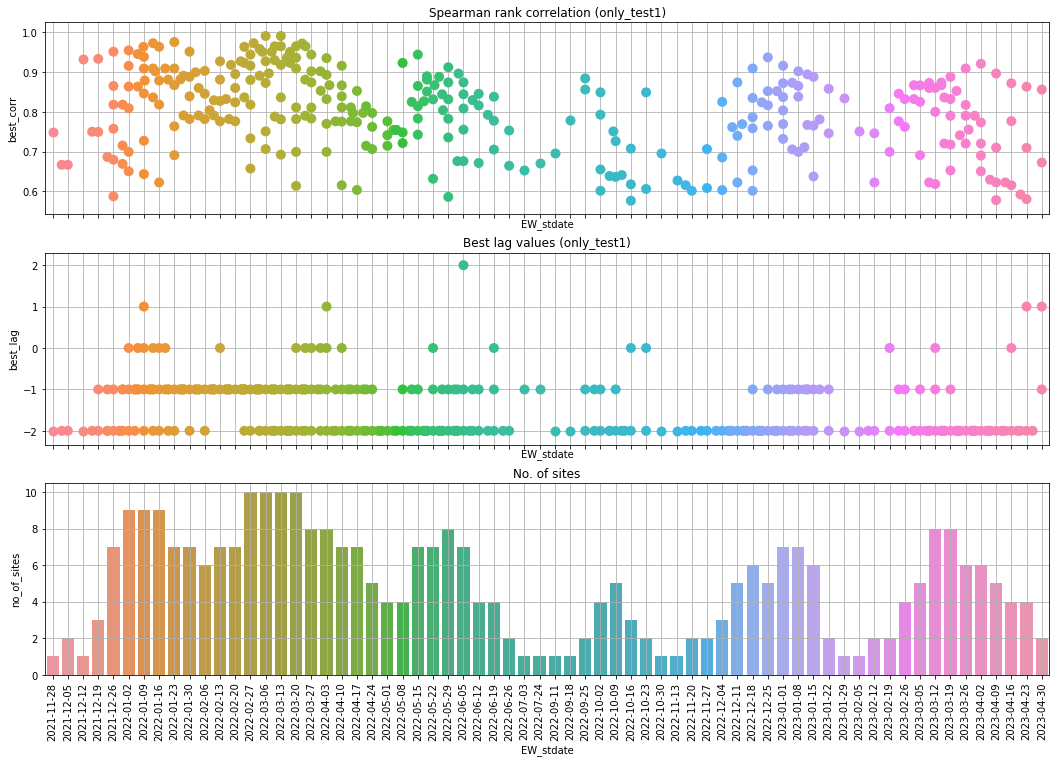

In [45]:
fig,axr=plt.subplots(3,1,figsize=(18,12),sharex=True)
ax=axr[0]
sns.swarmplot(x='EW_stdate', y='best_corr', data=pp[pp.best_corr>0],size=10,ax=ax)
ax.grid()
ax.set_title('Spearman rank correlation ({})'.format(test))
# xticks = ax.get_xticklabels()
# ax.set_xticklabels(xticks,rotation=90)

ax1=axr[1]
# fig,ax1=plt.subplots(1,1,figsize=(18,4),sharex=True)
sns.swarmplot(x='EW_stdate', y='best_lag', data=ppl,size=10,ax=ax1)
ax1.grid()
ax1.set_title('Best lag values ({})'.format(test))
# xticks = ax1.get_xticklabels()
# ax1.set_xticklabels(xticks,rotation=90)

ax2=axr[2]
# fig,ax2=plt.subplots(1,1,figsize=(18,4),sharex=True)
pp[pp.best_corr>0].groupby(['EW_stdate']).size()
sns.barplot(data=counts,x='EW_stdate',y='no_of_sites')
ax2.grid()
xticks = ax2.get_xticklabels()
ax2.set_xticklabels(xticks,rotation=90)
ax2.set_title('No. of sites')

In [54]:
pop=df[['sewershed','population_served']].drop_duplicates().sort_values(by='population_served',ascending=False)

In [56]:
allspdf.sewershed.unique()

array(['Aquia', 'Virginia Initiative Plant', 'Wolf Creek', 'Richmond',
       'Nansemond', 'Pound', 'Upper Occoquan', 'Little Falls Run',
       'Williamsburg', 'Onancock', 'HL Mooney'], dtype=object)

In [83]:
allspdf=pd.DataFrame()
samp='only_one'
if samp=='second':
    test='test2'
elif samp=='first':
    test='test1'
elif samp=='only_one':
    test='only_test1'
for l in locs:
    mdf=pd.read_csv('output/slope_pct/{}_one_samples_ST.csv'.format(l,samp))
    mdf.loc[:,'EW']=mdf.sample_collect_date.apply(lambda x: conv_epiweek(x))
    mdf.loc[:,'EW_stdate']=mdf.sample_collect_date.apply(lambda x: conv_epiweek_stdate(x))


    hdf=hospdf[hospdf.geo_value==l]
    codf=mdf.merge(hdf)

    temp=codf[['EW_stdate','log_viral_load','hosps_BOW_7d_avg','sewershed']]

    spdf=get_roll_spear(temp,l,shift=[-2,-1,0,1,2])
    spdf=spdf.dropna(subset=['sewershed','EW_stdate'])
    spdf.pcorr=spdf.pcorr.fillna(0)
    idx=spdf[spdf.pval<=0.05].groupby('EW_stdate')['pcorr'].idxmax()
    bspdf=spdf.loc[idx].rename(columns={'lag':'best_lag','pcorr':'best_corr','pval':'best_pval'})
    spdf=spdf.merge(bspdf,'outer')
    spdf.EW_stdate=pd.to_datetime(spdf.EW_stdate)
    allspdf=allspdf.append(spdf)
    print(l)
#     allspdf.to_csv('output/corr_two_samples/{}_sample_correlation.csv'.format(test),index=None)

,sewershed,EW,EW_stdate,population_served,flow_rate,pcr_target_avg_conc,pcr_target_below_lod,lod_sewage,viral_load,no_of_samples,test
0,Alexandria Renew,2022EW38,2022-09-18,300000,33.95,27060.285000,0.0,6200,3.480000e+12,2,test_mean
1,Alexandria Renew,2022EW39,2022-09-25,300000,34.00,30779.875000,0.0,6200,3.965000e+12,2,test_mean
2,Alexandria Renew,2022EW40,2022-10-02,300000,40.05,41755.202500,0.0,6200,6.110000e+12,2,test_mean
3,Alexandria Renew,2022EW41,2022-10-09,300000,35.00,49309.612500,0.0,6200,6.565000e+12,2,test_mean
4,Alexandria Renew,2022EW42,2022-10-16,300000,35.75,32281.850000,0.0,6200,4.360000e+12,2,test_mean
...,...,...,...,...,...,...,...,...,...,...,...
471,RockyMount,2023EW31,2023-07-30,5000,0.55,14881.000000,0.0,6200,3.070000e+10,2,test_mean
472,RockyMount,2023EW32,2023-08-06,5000,0.75,15650.000000,0.0,6200,4.225000e+10,2,test_mean
473,RockyMount,2023EW33,2023-08-13,5000,0.55,26983.000000,0.5,6200,5.600000e+10,2,test_mean
474,RockyMount,2023EW34,2023-08-20,5000,0.50,7659.500000,0.0,6200,1.545000e+10,2,test_mean


In [138]:
dmdf=ddf.groupby(['sewershed','EW'],as_index=False).mean()
dmdf.loc[:,'test']='test_mean'
dmdf.loc[:,'log_viral_load']=np.log10(dmdf['viral_load'])

In [141]:
dmdf=dmdf.merge(hospdf)

In [127]:
locs=dmdf.sewershed.unique()

In [132]:
allspdf=pd.DataFrame()
for l in locs:
    print(l)
    try:
        codf=dmdf[dmdf.sewershed==l]

        temp=codf[['EW_stdate','log_viral_load','hosps_BOW_7d_avg','sewershed']]

        spdf=get_roll_spear(temp,l,shift=[-2,-1,0,1,2])
        spdf=spdf.dropna(subset=['sewershed','EW_stdate'])
        spdf.pcorr=spdf.pcorr.fillna(0)
        idx=spdf[spdf.pval<=0.05].groupby('EW_stdate')['pcorr'].idxmax()
        bspdf=spdf.loc[idx].rename(columns={'lag':'best_lag','pcorr':'best_corr','pval':'best_pval'})
        spdf=spdf.merge(bspdf,'outer')
        spdf.EW_stdate=pd.to_datetime(spdf.EW_stdate)
        allspdf=allspdf.append(spdf)
    except Exception as e:
        print(e)

Alexandria Renew
Blacksburg
Coeburn Norton Wise
North River
Parkins Mill
Timestamp('2023-03-12 00:00:00')
Pepper's Ferry
Roanoke
Moores Creek
Lynchburg
RockyMount


In [133]:
pp,ppl=get_best_corr_lag(allspdf)

/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/

Text(0.5, 1.0, 'No. of sites')

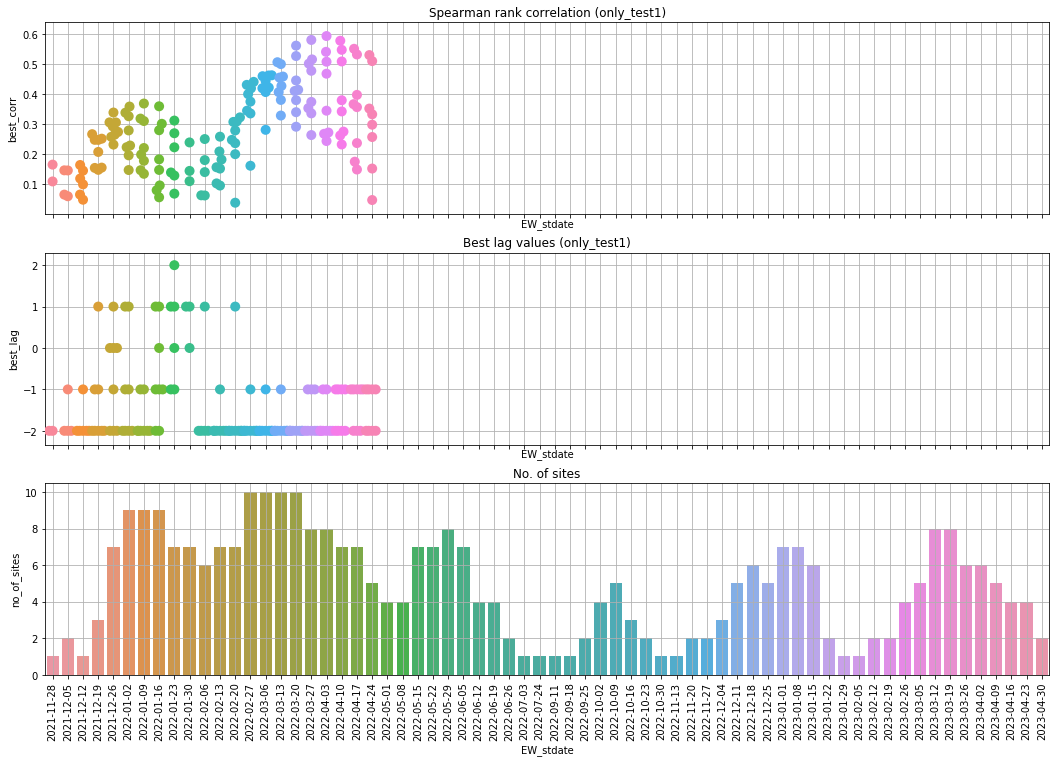

In [136]:
fig,axr=plt.subplots(3,1,figsize=(18,12),sharex=True)
ax=axr[0]
sns.swarmplot(x='EW_stdate', y='best_corr', data=pp[pp.best_corr>0],size=10,ax=ax)
ax.grid()
ax.set_title('Spearman rank correlation ({})'.format(test))
# xticks = ax.get_xticklabels()
# ax.set_xticklabels(xticks,rotation=90)

ax1=axr[1]
# fig,ax1=plt.subplots(1,1,figsize=(18,4),sharex=True)
sns.swarmplot(x='EW_stdate', y='best_lag', data=ppl,size=10,ax=ax1)
ax1.grid()
ax1.set_title('Best lag values ({})'.format(test))
# xticks = ax1.get_xticklabels()
# ax1.set_xticklabels(xticks,rotation=90)

ax2=axr[2]
# fig,ax2=plt.subplots(1,1,figsize=(18,4),sharex=True)
pp[pp.best_corr>0].groupby(['EW_stdate']).size()
sns.barplot(data=counts,x='EW_stdate',y='no_of_sites')
ax2.grid()
xticks = ax2.get_xticklabels()
ax2.set_xticklabels(xticks,rotation=90)
ax2.set_title('No. of sites')